<h2> Global Historical Climate Network Daily (GHCN-D) data in BigQuery </h2>

If you routinely analyze data to make better decisions (or if you build machine learning models to provide such guidance automatically), weather should be one of your inputs.  Having GHCN data in BigQuery just made that a whole lot easier.

Install basemap (to draw maps), restart the kernel, then start with some Python imports

In [1]:
%bash
echo 'Y' | apt-get install python-mpltoolkits.basemap

Reading package lists...
Building dependency tree...
Reading state information...
python-mpltoolkits.basemap is already the newest version.
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import datalab.bigquery as bq
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import shutil

Let’s take a simple example. Let’s say you are a pizza chain based in Chicago and want to grab some weather variables that might affect demand for pizza and pizza delivery times. The first thing to do is to find the GHCN station closest to you.  Go to Google Maps and find your latitude and longitude (say this turns out to be 42 degrees latitude and -87.9 degrees longitude)

In [3]:
%sql --module find_stations_close_to
SELECT
  name, id,
  state,
  latitude,
  longitude,
  DEGREES(ACOS(SIN(RADIANS(latitude)) * SIN(RADIANS($lat)) + COS(RADIANS(latitude)) * COS(RADIANS($lat)) * COS(RADIANS(longitude - $lon)))) * 60 * 1.515 * 1.609344 AS dist_kms
FROM
  [bigquery-public-data:ghcn_d.ghcnd_stations]
ORDER BY
  dist_kms ASC
LIMIT
  1000

In [4]:
stations = bq.Query(find_stations_close_to, lat=42, lon=-87.9).to_dataframe()
stations[:5]

,name,id,state,latitude,longitude,dist_kms
0,CHICAGO OHARE INTL AP,USW00094846,IL,41.9950,-87.9336,3.725451
1,PARK RIDGE 0.7 WNW,US1ILCK0192,IL,42.0168,-87.8557,5.406311
2,DES PLAINES 0.5 NW,US1ILCK0046,IL,42.0398,-87.9083,5.891779
3,PARK RIDGE 0.5 SSW,US1ILCK0180,IL,42.0044,-87.8460,5.905546
4,DES PLAINES 1 NW,USC00112286,IL,42.0500,-87.9167,7.536246


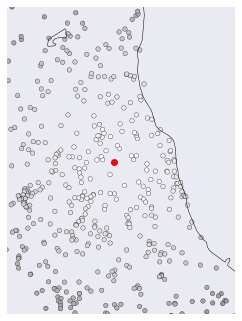

In [5]:
clat = 42
clon = -87.9
m = Basemap(resolution='h',projection='merc', llcrnrlat=clat-.5,urcrnrlat=clat+.5,llcrnrlon=clon-.5,urcrnrlon=clon+.5,lat_ts=51.0)
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
ax = plt.subplot(111)
x,y = m(stations['longitude'].values,stations['latitude'].values)
m.scatter(x,y,c=stations['dist_kms'].values)
ax.plot([x[0]], [y[0]], 'or')

<h3> Weather data </h3>

Next, we need to pull data from this station (USW00094846) on the dates of interest. Here, I will query the table of 2015 data and pull all the days from that table. To get the rainfall amount (“precipitation” or PRCP) in millimeters, you’d write:

In [6]:
%sql
SELECT
  STRING(wx.date) AS date,
  wx.value/10.0 AS prcp
FROM
  [bigquery-public-data:ghcn_d.ghcnd_2015] AS wx
WHERE
  id = 'USW00094846'
  AND qflag IS NULL
  AND element = 'PRCP'
ORDER BY wx.date

date,prcp
2015-01-01,0.0
2015-01-02,0.0
2015-01-03,14.5
2015-01-04,3.3
2015-01-05,3.8
2015-01-06,0.3
2015-01-07,0.0
2015-01-08,1.5
2015-01-09,0.0
2015-01-10,0.0


In [7]:
%sql --module wxquery
SELECT
  STRING(wx.date) AS date,
  MAX(prcp) AS prcp,
  MAX(tmin) AS tmin,
  MAX(tmax) AS tmax,
  IF(MAX(haswx) = 'True', 'True', 'False') AS haswx
FROM (
  SELECT
    wx.date,
    IF (wx.element = 'PRCP', wx.value/10, NULL) AS prcp,
    IF (wx.element = 'TMIN', wx.value/10, NULL) AS tmin,
    IF (wx.element = 'TMAX', wx.value/10, NULL) AS tmax,
    IF (SUBSTR(wx.element, 0, 2) = 'WT', 'True', NULL) AS haswx
  FROM
    [bigquery-public-data:ghcn_d.ghcnd_$year] AS wx
  WHERE
    id = 'USW00094846'
    AND qflag IS NULL )
GROUP BY
  date
ORDER BY
  date

In [8]:
wx = bq.Query(wxquery, year=2015).to_dataframe()
wx[:5]

,date,prcp,tmin,tmax,haswx
0,2015-01-01,0.0,-9.9,0.0,False
1,2015-01-02,0.0,-9.3,1.1,False
2,2015-01-03,14.5,-1.6,1.1,True
3,2015-01-04,3.3,-16.6,0.6,True
4,2015-01-05,3.8,-19.3,-14.3,True


<h3> Plot timeseries of weather data </h3>

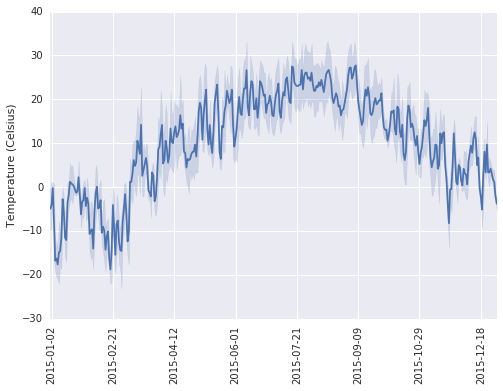

In [9]:
# Plot the average value
ax = (0.5*(wx['tmin']+wx['tmax'])).plot()
x = np.arange(len(wx.date))
palette = sns.color_palette()
ax.fill_between(x, wx['tmin'].values, wx['tmax'].values, alpha=.2, color=palette.pop(0))
ax.set_ylabel("Temperature (Celsius)")
import matplotlib.ticker as plticker
junk = plt.xticks(x[1::50], wx['date'].values[1::50], rotation='vertical')

<h3> Mash up with airline data </h3>



In [10]:
%sql --module airwxquery
SELECT
  wx.date,
  wx.prcp,
  f.departure_delay,
  f.arrival_airport
FROM (
  SELECT
    STRING(date) AS date,
    value/10 AS prcp
  FROM
    [bigquery-public-data:ghcn_d.ghcnd_2005]
  WHERE
    id = 'USW00094846'
    AND qflag IS NULL
    AND element = 'PRCP') AS wx
JOIN
  [bigquery-samples:airline_ontime_data.flights] AS f
ON
  f.date = wx.date
WHERE
  f.departure_airport = 'ORD'

In [11]:
airwx = bq.Query(airwxquery).to_dataframe()
airwx[:5]

,wx_date,wx_prcp,f_departure_delay,f_arrival_airport
0,2005-04-01,3.8,-4.0,DCA
1,2005-04-02,0.8,-5.0,DCA
2,2005-04-03,0.0,20.0,DCA
3,2005-04-04,0.0,-5.0,DCA
4,2005-04-05,0.0,-3.0,DCA


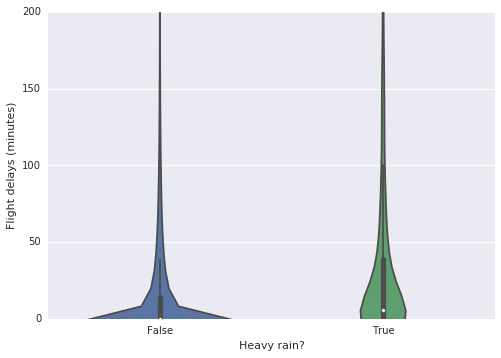

In [12]:
rainyday = airwx.wx_prcp > 25.4 # 1 inch of rain
ax = sns.violinplot(x=rainyday, y=airwx.f_departure_delay)
ax.set_ylim(0, 200)
ax.set_xlabel('Heavy rain?')
ax.set_ylabel('Flight delays (minutes)')

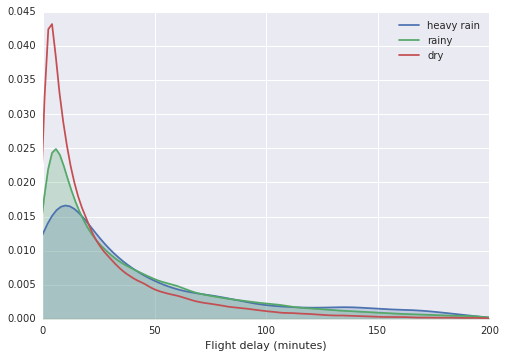

In [13]:
limited = airwx[airwx.f_departure_delay > 0]
limited = limited[limited.f_departure_delay < 200]
heavy = limited.wx_prcp > 25.4 # 1 inch of rain
rainy = limited.wx_prcp > 0
ax = sns.kdeplot(limited.f_departure_delay[heavy], shade=True, label='heavy rain')
ax = sns.kdeplot(limited.f_departure_delay[rainy], shade=True, label='rainy')
ax = sns.kdeplot(limited.f_departure_delay[np.logical_not(rainy)], shade=False, label='dry')
ax.set_xlim(0,200)
ax.set_xlabel('Flight delay (minutes)')

<h3> GHCN station locations </h3>

In [14]:
%sql --module all_stations
SELECT
  name, 
  value/10 AS min_temperature,
  latitude,
  longitude
FROM
  [bigquery-public-data:ghcn_d.ghcnd_stations] AS stn
JOIN
  [bigquery-public-data:ghcn_d.ghcnd_2016] AS wx
ON
  wx.id = stn.id
WHERE
  wx.element = 'TMIN'
  AND wx.qflag IS NULL
  AND STRING(wx.date) = '2016-08-15'

In [15]:
stations = bq.Query(all_stations).to_dataframe()
stations[:5]

,name,min_temperature,latitude,longitude
0,GAVAR,9.0,40.3500,45.1331
1,VILLA REYNOLDS,5.8,-33.7300,-65.3870
2,CABRAMURRA SMHEA,1.4,-35.9383,148.3842
3,MALAHAT,16.6,48.5667,-123.5333
4,CAMPBELL RIVER A,14.0,49.9500,-125.2667


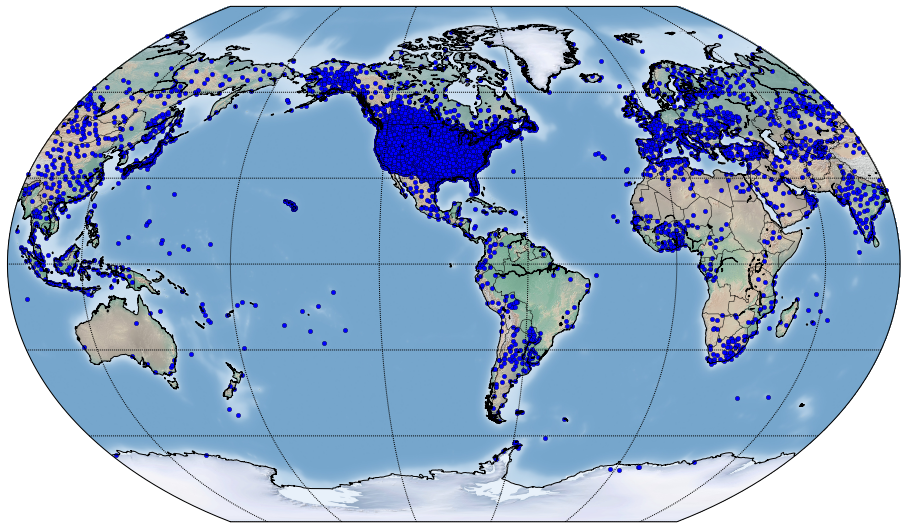

In [16]:
mpl.rcParams['figure.figsize'] = '16, 12'
m = Basemap(projection='kav7', lon_0=-90, resolution = 'l', area_thresh = 1000.0)
m.shadedrelief(scale=0.2)
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(-90.,99.,30.))
junk = m.drawmeridians(np.arange(-180.,180.,60.))
x,y = m(stations['longitude'].values,stations['latitude'].values)
m.scatter(x,y)